# 21-01 주제분석 3주차 패키지

- 주제분석 3주차 분석 툴은 Python/R 둘 다 가능합니다. 
    - 1-3주차 패키지 문제의 조건 및 힌트는 Python을 기준으로 하지만, R을 사용해도 무방합니다.
    - 다만 2/3주차의 머신러닝/딥러닝 모듈을 편하게 사용하기 위해서는 Python이 더 편할겁니다.

- 제출형식은 pdf/html/doc/ppt 등 발표가 가능하면 괜찮습니다. 하지만 html로 주시면 가장 감사합니다.

- 패키지 과제 발표는 세미나 쉬는시간 이후에 하게 되며, 역시 랜덤으로 5시00분에 발표됩니다.

- 제출기한은 목요일 자정까지이며 지각시 벌금 5000원이 있습니다. 미제출 시 만원입니다. 
    - 패키지 2회 무단 미제출 시 퇴출이니 유의해 주세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.cat_boost import CatBoostEncoder
import lightgbm as lbm
from lightgbm import LGBMModel, LGBMRegressor

- 이번주에 다룰 내용은 머신러닝 모델의 해석/기본적인 딥러닝입니다.
- 더불어서 다뤄지지는 내용은 randomness control입니다.
- 먼저 주어진 코드를 실행하세요.

In [2]:
train = pd.read_csv('train.csv')
test=  pd.read_csv('test.csv')

train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]
test_x = test.drop(['price'], axis = 1)
test_y = np.sqrt(test.loc[:, ['price']])

feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

best_lgbm_reg = LGBMRegressor(learning_rate = 0.3)
best_lgbm_reg.fit(train_cbe, train_y)

LGBMRegressor(learning_rate=0.3)

## 1. Interpretable ML

해석가능한 머신러닝은 모델의 결과를 해석하기 위한 방법들입니다. 보통 랜덤포레스트(Random Forest)에서 Feature(Variable) Importance에 대해 들어본 적이 있을텐데, 그것과 유사합니다. Interpretable ML 방법의 특징은 어떤 모델에도 다 적용이 가능하다는건데, SVM이나 Neural Net같이 해석이 불가능하다고 알려진 모델들도 어떤 변수들이 모델을 만드는데 있어서 주요하게 사용되었는지를 파악할 수 있게 해줍니다. 물론 회귀분석처럼 '다른 변수들을 고정시킨 상황에서 $x_1$이 한단위 증가하면 $y$가 평균적으로 $\beta_1$만큼 증가한다' 라고 말할수는 없지만요!

Feature Importance/Partial Dependence Plot/Lime/SHAP 에 대한 해석은 조금 조심해야할 필요가 있습니다. 밑의 링크의 '모델해석 및 이탈원인 분석'을 참고하면 되는데, 처음에 딱 이해하기 쉬운 개념은 아니지만 나중에 보다보면 더 이해가 잘 되실 것 같아요.

https://danbi-ncsoft.github.io/competition/2019/02/19/big-contest-2018-retrospect.html

나중에 관심있으시면 이 책을 보는 것을 추천드립니다. 저도 아직 안봄 ㅎ

https://christophm.github.io/interpretable-ml-book/

#### **오늘의 해석은 각각 방법에 입각해서 엄밀하게 해석할 필요없이, 그냥 가볍게 해석해주시면 됩니다!**

### 1.1 모델 불러오기

주어진 패키지를 불러오고, `lgbm.pkl`을 불러오세요.

In [3]:
#1.1
import pickle
import joblib

with open('lgbm.pkl', 'rb') as f:
    model = pickle.load(f)
model

LGBMRegressor(learning_rate=0.3)

### 1.2 Feature Importance 확인과 해석

- 불러온 모델에 대해 `plot_importance`함수를 통해 Feature Importance를 시각화해주세요.
- 결과에 대해 간단히 해석해주세요.

여기서 Feature Importance는 Permutation를 통한 중요도를 보는 것이 아니고, tree 모델 자체의 구성에서 어떤 변수가 지니불순도를 잘 줄였는지를 확인한 것이라고 이해해주시면 됩니다. 

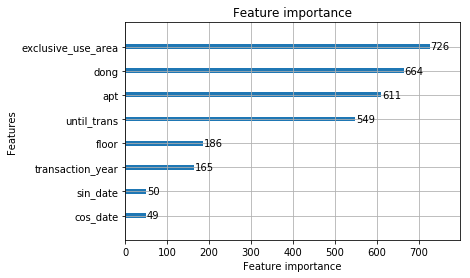

In [4]:
lbm.plot_importance(model)

지니불순도 - tree의 노드에 샘플들이 이질적으로 구성되어 있을 경우 지니 불순도는 높아진다.


lightgbm은 tree 형태의 모델인데, 이 tree에서 exclusive_use_area 변수가 불순도를 가장 크게 감소시킨다고 해석할 수 있다

**이제는 불러온 모델 말고, `best_lgbm_reg`를 사용하세요.**

### 1.3 Randomness Control

- `random, numpy` 패키지의 난수를 42로 고정하세요.
- 더불어서 `os` 패키지의 난수도 고정해야합니다.

Permutation 방식의 Feature Importance를 시행한건데, permutation자체에 랜덤성이 있다보니 결과가 재현 가능하도록 시드를 고정해줍니다.

파이썬의 시드 고정은 R처럼 그냥 `set.seed()`한다고 해서 고정되지 않습니다. 전체 파이썬과 여러 패키지들의 randomness를 각각 고정해주어야 재현가능해집니다. 정말 귀찮고, 딥러닝의 경우 GPU를 사용할 경우 GPU의 계산과 관련된 시드를 고정하면 속도가 상당히 느려진다고 알려져 있습니다. 더불어서 재현도 100%되진 않으며 성능도 살짝 떨어진다고는 하지만, GPU를 사용하지 않는 경우에는 문제가 없고 최소한 할줄은 알아야겠죠?

더불어서 왜 저런식으로 복잡하게 구성이 되는가?에 대해 궁금할 수 있는데 찾아본 적은 없지만 아마도 `numpy`는 c++가 뒤에서 연산을 해주는 것으로 알고있고(그래서 빠름!), `random`은 그냥 파이썬이고, `os`는 우리 os를 건드리는 것이 아닐까....? 추측입니다 :)

In [5]:
#1.3
import os
import random
random.seed(42)
np.random.seed(42)


### 1.4 Permutation Feature Importance

- permutation feature importance를 계산하기 위해 `best_lgbm_reg`를 `permutation_importance`함수를 사용해 test set에 적합하세요.
- permutation feature importance를 시각화해주세요.

위의 1.2에서는 train에서 변수중요도를 보고, 지금은 test에서 봐서 좀 이상하다고 생각할수도 있습니다. 편의를 위해, 그리고 실제로 변수중요도에 대한 부분에서 어떤 set에 대해 봐야하는지가 100% 정답처럼 있는 것은 아니라고 알고 있어요.(물론 제가 틀렸을수도!) 아무튼 너무 신경쓰지말고 해주세요!

In [6]:
#1.4
from sklearn.inspection import permutation_importance
res = permutation_importance(best_lgbm_reg,test_cbe, test_y)

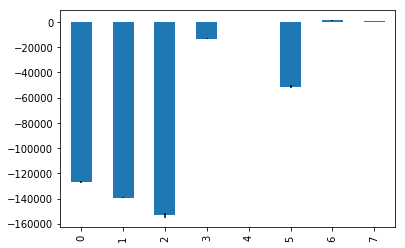

In [7]:
imp = pd.Series(res.importances_mean)
imp.plot.bar(yerr=res.importances_std)

### 1.5 SHAP(SHapley Additive exPlanations)의 확인과 해석

- SHAP Value를 구하고 간단한 해석을 해주세요.
- `shap.TreeExplainer`, `shap_values`, `shap.summary_plot` 정도의 함수만 사용하면 됩니다.
- 결과가 좀 다른건 상관없습니다.

In [8]:
#1.5
import shap
explainer = shap.TreeExplainer(best_lgbm_reg)
shap_values = explainer.shap_values(train_cbe)

C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vbnmz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

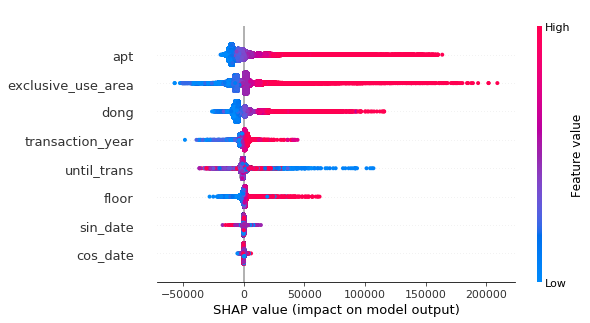

In [9]:
shap.summary_plot(shap_values, train_cbe)

apt,exclusive_use_area, dong, transaction_year,floor 변수의 값이 높을수록 가격이 높은 경향이 있다

until_trans 변수의 값이 낮을수록 예상 가격이 높은 경향성이 있다

나머지 변수는 상관성을 파악하기 어렵다

## 2. 딥러닝 기본

딥러닝 정말 간단히 해볼겁니다!

### 2.1 주어진 코드를 실행하고, 현재 신경망의 구조에 대해 간단히 설명해주세요.

In [10]:
#2.1
train = pd.read_csv('train.csv')
train_x = train.drop(['price'], axis = 1)
train_y = train.loc[:, ['price']]

val_x = train_x[train['transaction_year'] == 4]
val_y = train_y[train['transaction_year'] == 4]
train_tune_x = train_x[train['transaction_year'] < 4]
train_tune_y = train_y[train['transaction_year'] < 4]

CBE_encoder = CatBoostEncoder()
train_tune_cbe = CBE_encoder.fit_transform(train_tune_x[feature_list], train_tune_y)
val_cbe = CBE_encoder.transform(val_x[feature_list])

In [11]:
import tensorflow as tf
import keras
from keras import metrics
from keras import models
from keras import layers
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [12]:
def build_model():
    model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = keras.optimizers.RMSprop(0.0001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
    return model

In [13]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2304      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________


4개의 hiddden layer로 구성되어 있으며 각 layer는 256, 64, 32, 1개의 output을 결과로 낸다.

### 2.2 training loss와 validation loss를 시각화하세요.

- 본인 컴에서 돌리면 꽤나 돌아갈수도 있어요. 주분과 함께하려면 패키지가 코랩으로 가거나, 주분이 코랩으로 가면 한번에 투 컴을 돌릴 수 있습니다.

In [15]:
#2.2
history = model.fit(train_tune_cbe, train_tune_y, epochs=300, validation_data = (val_cbe, val_y), batch_size = 512)

W0506 17:45:31.053600 36916 deprecation_wrapper.py:119] From C:\Users\vbnmz\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 312466 samples, validate on 109698 samples
Epoch 1/300
312466/312466 [==============================] - 3s 10us/step - loss: 441217023.0497 - mse: 441216960.0000 - val_loss: 326224818.8672 - val_mse: 326224800.0000
Epoch 2/300
312466/312466 [==============================] - 3s 10us/step - loss: 232555916.7627 - mse: 232555904.0000 - val_loss: 341022206.0873 - val_mse: 341022272.0000
Epoch 3/300
312466/312466 [==============================] - 3s 10us/step - loss: 232284114.9962 - mse: 232284032.0000 - val_loss: 342789922.0347 - val_mse: 342789888.0000
Epoch 4/300
312466/312466 [==============================] - 3s 10us/step - loss: 231966956.5652 - mse: 231966944.0000 - val_loss: 327348914.0440 - val_mse: 327348960.0000
Epoch 5/300
312466/312466 [==============================] - 3s 9us/step - loss: 231694103.3777 - mse: 231694160.0000 - val_loss: 324929219.1986 - val_mse: 324929120.0000
Epoch 6/300
312466/312466 [==============================] - 3s 10us/step - loss: 2312845

Method (on_train_batch_end) is slow compared to the batch update (0.115828). Check your callbacks.


312466/312466 [==============================] - 4s 14us/step - loss: 201144727.6927 - mse: 201144736.0000 - val_loss: 290442703.3647 - val_mse: 290442688.0000
Epoch 36/300
312466/312466 [==============================] - 4s 12us/step - loss: 200138981.6983 - mse: 200138896.0000 - val_loss: 309553766.7842 - val_mse: 309553792.0000
Epoch 37/300
312466/312466 [==============================] - 3s 10us/step - loss: 199493821.4766 - mse: 199493936.0000 - val_loss: 270395763.8615 - val_mse: 270395776.0000
Epoch 38/300
312466/312466 [==============================] - 3s 10us/step - loss: 198950343.0758 - mse: 198950336.0000 - val_loss: 290999089.4514 - val_mse: 290999104.0000
Epoch 39/300
312466/312466 [==============================] - 3s 10us/step - loss: 198460919.3786 - mse: 198460800.0000 - val_loss: 328824257.9752 - val_mse: 328824128.0000
Epoch 40/300
312466/312466 [==============================] - 3s 11us/step - loss: 197998092.5056 - mse: 197998000.0000 - val_loss: 285896514.9470 -

312466/312466 [==============================] - 3s 10us/step - loss: 184581873.9915 - mse: 184581824.0000 - val_loss: 276697454.1538 - val_mse: 276697536.0000
Epoch 83/300
312466/312466 [==============================] - 3s 10us/step - loss: 184269646.5109 - mse: 184269504.0000 - val_loss: 255486949.2448 - val_mse: 255486944.0000
Epoch 84/300
312466/312466 [==============================] - 3s 10us/step - loss: 183879420.9698 - mse: 183879328.0000 - val_loss: 287522589.0104 - val_mse: 287522656.0000
Epoch 85/300
312466/312466 [==============================] - 3s 10us/step - loss: 184071899.3018 - mse: 184071824.0000 - val_loss: 377015078.3356 - val_mse: 377015072.0000
Epoch 86/300
312466/312466 [==============================] - 3s 10us/step - loss: 184215800.0766 - mse: 184215776.0000 - val_loss: 318050346.1013 - val_mse: 318050400.0000
Epoch 87/300
312466/312466 [==============================] - 3s 11us/step - loss: 183728676.0243 - mse: 183728640.0000 - val_loss: 282880340.5956 -

312466/312466 [==============================] - 3s 10us/step - loss: 177979185.8960 - mse: 177979120.0000 - val_loss: 260134866.9317 - val_mse: 260134864.0000
Epoch 130/300
312466/312466 [==============================] - 3s 9us/step - loss: 177676261.4454 - mse: 177676288.0000 - val_loss: 358357980.4470 - val_mse: 358357920.0000
Epoch 131/300
312466/312466 [==============================] - 3s 10us/step - loss: 177640524.6192 - mse: 177640512.0000 - val_loss: 354161776.2541 - val_mse: 354161888.0000
Epoch 132/300
312466/312466 [==============================] - 3s 10us/step - loss: 177521272.1013 - mse: 177521232.0000 - val_loss: 291877838.3556 - val_mse: 291877856.0000
Epoch 133/300
312466/312466 [==============================] - 3s 10us/step - loss: 177181908.5211 - mse: 177181920.0000 - val_loss: 269440756.6978 - val_mse: 269440768.0000
Epoch 134/300
312466/312466 [==============================] - 3s 10us/step - loss: 177535722.1849 - mse: 177535776.0000 - val_loss: 254831990.38

312466/312466 [==============================] - 3s 9us/step - loss: 172763719.7533 - mse: 172763664.0000 - val_loss: 242508843.9878 - val_mse: 242508848.0000
Epoch 177/300
312466/312466 [==============================] - 3s 10us/step - loss: 172690177.3439 - mse: 172690176.0000 - val_loss: 264708462.9942 - val_mse: 264708496.0000
Epoch 178/300
312466/312466 [==============================] - 3s 9us/step - loss: 172731676.2963 - mse: 172731600.0000 - val_loss: 326584359.8989 - val_mse: 326584480.0000
Epoch 179/300
312466/312466 [==============================] - 3s 10us/step - loss: 172575616.8463 - mse: 172575664.0000 - val_loss: 302323569.8643 - val_mse: 302323584.0000
Epoch 180/300
312466/312466 [==============================] - 3s 10us/step - loss: 172705523.2153 - mse: 172705600.0000 - val_loss: 299535443.3153 - val_mse: 299535488.0000
Epoch 181/300
312466/312466 [==============================] - 3s 9us/step - loss: 172367253.3715 - mse: 172367264.0000 - val_loss: 301970679.5769

312466/312466 [==============================] - 3s 10us/step - loss: 169009850.5322 - mse: 169009840.0000 - val_loss: 272454840.6165 - val_mse: 272454848.0000
Epoch 224/300
312466/312466 [==============================] - 3s 10us/step - loss: 168438405.0430 - mse: 168438464.0000 - val_loss: 329733372.7387 - val_mse: 329733376.0000
Epoch 225/300
312466/312466 [==============================] - 3s 10us/step - loss: 168573351.6414 - mse: 168573264.0000 - val_loss: 330655979.9105 - val_mse: 330656064.0000
Epoch 226/300
312466/312466 [==============================] - 3s 10us/step - loss: 168404233.2218 - mse: 168404192.0000 - val_loss: 286957093.9844 - val_mse: 286957120.0000
Epoch 227/300
312466/312466 [==============================] - 3s 9us/step - loss: 168276697.0609 - mse: 168276736.0000 - val_loss: 243408385.0515 - val_mse: 243408448.0000
Epoch 228/300
312466/312466 [==============================] - 3s 10us/step - loss: 167994333.7320 - mse: 167994336.0000 - val_loss: 236619540.37

312466/312466 [==============================] - 3s 11us/step - loss: 163026974.5967 - mse: 163027088.0000 - val_loss: 364609537.0023 - val_mse: 364609472.0000
Epoch 271/300
312466/312466 [==============================] - 3s 11us/step - loss: 162521904.4559 - mse: 162521936.0000 - val_loss: 345919027.6137 - val_mse: 345919168.0000
Epoch 272/300
312466/312466 [==============================] - 3s 11us/step - loss: 162458855.6545 - mse: 162458800.0000 - val_loss: 293451915.1282 - val_mse: 293451904.0000
Epoch 273/300
312466/312466 [==============================] - 4s 11us/step - loss: 162454672.8939 - mse: 162454736.0000 - val_loss: 234096926.9621 - val_mse: 234096944.0000
Epoch 274/300
312466/312466 [==============================] - 4s 11us/step - loss: 162098700.6141 - mse: 162098752.0000 - val_loss: 256463414.2175 - val_mse: 256463424.0000
Epoch 275/300
312466/312466 [==============================] - 4s 12us/step - loss: 162159745.5608 - mse: 162159680.0000 - val_loss: 319783694.5

In [16]:
val_loss = history.history['val_loss']
loss = history.history['loss']

Text(0, 0.5, 'loss')

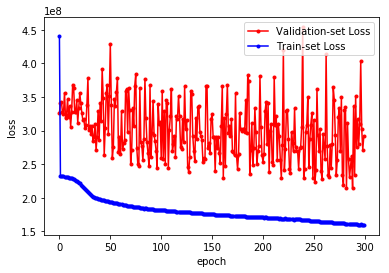

In [17]:
plt.plot(val_loss, marker='.', c='red', label="Validation-set Loss")
plt.plot(loss, marker='.', c='blue', label="Train-set Loss")
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')

### 2.3 어떤문제가 발생했는지 설명해주세요.

- 꼭 써주세요.

힌트

- 이전에 lgbm 같은 경우 validation mse가 $1.2 * 10^8$ 이였습니다.

lgbm의 validation mse가 1.2*10^8, 딥러닝 모델의 validation mse가 2.7*10^8으로 딥러닝 모델이 더 크다

그리고 딥러닝 모델의 경우 validation loss가 위아래로 진동하고 있어 학습이 원활하게 되지 않는 모습이다

### 2.4 더 좋은 성능의 딥러닝 모델을 위해

- test set에 대해 딥러닝 모형의 성능을 평가하세요.
- dense 조절, batch_size 조절, regularization, dropout, batch normalization 등의 방법을 활용해 최고의 성능을 얻어보세요.
- 만약 성능의 향상이 어렵다면, 다양한 방법들을 시도하는 것을 목표로 해주세요!

In [18]:
def build_model():
    model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_tune_cbe.keys())]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = keras.optimizers.RMSprop(0.0001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
    return model


In [19]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               2304      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [20]:
history = model.fit(train_tune_cbe, train_tune_y, epochs=100, validation_data = (val_cbe, val_y), batch_size = 512)

Train on 312466 samples, validate on 109698 samples
Epoch 1/100
312466/312466 [==============================] - 11s 37us/step - loss: 3074659078.8247 - mse: 3074659584.0000 - val_loss: 4169722262.2796 - val_mse: 4169721856.0000 loss: 3073114861.3176 - mse: 3073114624.0 - ETA: 1s - loss: 3074080752.1
Epoch 2/100
312466/312466 [==============================] - 10s 33us/step - loss: 3073253780.1062 - mse: 3073252864.0000 - val_loss: 4167568800.1884 - val_mse: 4167569152.0000
Epoch 3/100
312466/312466 [==============================] - 10s 33us/step - loss: 3071096245.5987 - mse: 3071096576.0000 - val_loss: 4164257939.0965 - val_mse: 4164257280.0000
Epoch 4/100
312466/312466 [==============================] - 9s 29us/step - loss: 3067930608.4794 - mse: 3067930112.0000 - val_loss: 4159514074.2271 - val_mse: 4159514368.0000
Epoch 5/100
312466/312466 [==============================] - 10s 32us/step - loss: 3063500709.3194 - mse: 3063501312.0000 - val_loss: 4153373704.8306 - val_mse: 4153374

312466/312466 [==============================] - 10s 32us/step - loss: 659887739.8016 - mse: 659887296.0000 - val_loss: 885062760.6784 - val_mse: 885062848.0000
Epoch 45/100
312466/312466 [==============================] - 11s 35us/step - loss: 573271804.2500 - mse: 573272000.0000 - val_loss: 1122029916.7836 - val_mse: 1122029696.0000
Epoch 46/100
312466/312466 [==============================] - 10s 33us/step - loss: 493190390.4586 - mse: 493190432.0000 - val_loss: 699111831.5842 - val_mse: 699111872.0000
Epoch 47/100
312466/312466 [==============================] - 10s 32us/step - loss: 420781355.7996 - mse: 420781184.0000 - val_loss: 505408650.5156 - val_mse: 505408512.0000
Epoch 48/100
312466/312466 [==============================] - 10s 33us/step - loss: 355938853.0061 - mse: 355938848.0000 - val_loss: 514100009.8411 - val_mse: 514099968.0000
Epoch 49/100
312466/312466 [==============================] - 10s 32us/step - loss: 300437273.4467 - mse: 300437248.0000 - val_loss: 67618837

312466/312466 [==============================] - 10s 33us/step - loss: 160401471.1688 - mse: 160401456.0000 - val_loss: 190627699.8135 - val_mse: 190627664.0000
Epoch 91/100
312466/312466 [==============================] - 10s 31us/step - loss: 158932211.2320 - mse: 158932256.0000 - val_loss: 219107670.2665 - val_mse: 219107648.0000
Epoch 92/100
312466/312466 [==============================] - 10s 32us/step - loss: 158666930.7652 - mse: 158666976.0000 - val_loss: 182219801.1779 - val_mse: 182219808.0000
Epoch 93/100
312466/312466 [==============================] - 10s 32us/step - loss: 160412084.0701 - mse: 160412048.0000 - val_loss: 199135227.0672 - val_mse: 199135280.0000
Epoch 94/100
312466/312466 [==============================] - 10s 32us/step - loss: 158639877.0341 - mse: 158639904.0000 - val_loss: 200874212.8306 - val_mse: 200874192.0000
Epoch 95/100
312466/312466 [==============================] - 10s 33us/step - loss: 159922779.8065 - mse: 159922704.0000 - val_loss: 176783320.

Text(0, 0.5, 'loss')

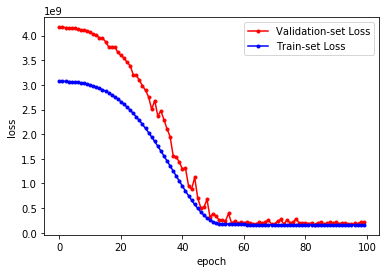

In [21]:
val_loss = history.history['val_loss']
loss = history.history['loss']
plt.plot(val_loss, marker='.', c='red', label="Validation-set Loss")
plt.plot(loss, marker='.', c='blue', label="Train-set Loss")
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')

In [22]:
feature_list = list(train_x.columns)

CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train_x[feature_list], train_y)
test_cbe = CBE_encoder.transform(test_x[feature_list])

In [28]:
from sklearn.metrics import mean_squared_error
pred = model.predict(test_cbe)
mean_squared_error(test_y, np.sqrt(pred))

780.4163187340346